## This is the step of filtering in the Mapper's construction.
## We project our multidimensional data in 2D euclidean space. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
import numpy as np
import json
from scipy.stats import zscore
from numpy.linalg import svd
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.manifold import TSNE, SpectralEmbedding,Isomap
from sklearn.decomposition import KernelPCA
from colorspace import sequential_hcl

import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.collections import LineCollection,PatchCollection
from matplotlib.patches import Rectangle

%run functions-py.py

In [4]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))

In [5]:
suspense=np.load("../Data/avg_suspense.npy")

In [6]:
t_s=176
array=np.zeros((3,t_s,2))

In [7]:
names=['a']*2
names[0]='all_l1-thres'
names[1]='all_l1-nothres'

In [8]:
filts=['se','iso','cmds']

In [9]:
names_filts=[a+"_"+b for a in names for b in filts]
names_filts

['all_l1-thres_se',
 'all_l1-thres_iso',
 'all_l1-thres_cmds',
 'all_l1-nothres_se',
 'all_l1-nothres_iso',
 'all_l1-nothres_cmds']

In [10]:
embs=['a']*2

In [11]:
w=8

### Distance between matrices of points (considering All-All, threshold)

In [12]:
i=0

In [13]:
#og_dist=np.load('../Data/dist/all_l1_notemp.npy')
og_dist=np.load('../Data/dist/'+ names[i]+ '.npy')

In [15]:
embs[i]={}

In [16]:
n_neigh=30

In [17]:
## Spectral embedding/Laplacian eigenmaps
Aff=affinity_matrix(og_dist,n_neighbors=n_neigh,heat_kernel=False)
#plt.imshow(Aff.toarray())
if(not check_connected(Aff.toarray())):
     raise ValueError('Matrix is not connected')
else:
    se=SpectralEmbedding(n_components=2,affinity='precomputed')
    emb=se.fit_transform(Aff)
embs[i]["se"]=emb
array[3*i,:,:]=emb

In [18]:
# Isometric mapping
iso=Isomap(n_neighbors=n_neigh,n_components=2,metric='precomputed')
#emb=iso.fit_transform(new_dist)
emb=iso.fit_transform(og_dist)
embs[i]["iso1"]=emb
array[3*i+1,:,:]=emb

In [19]:
#Classical multidimensional scaling
emb,e=cmdscale(og_dist,2)
embs[i]["cmds"]=emb
array[3*i+2,:,:]=emb

In [114]:
#Equal as cmds
# kPCA=KernelPCA(n_components=2,kernel='precomputed')
# new_dist = og_dist **2
# new_dist*=-0.5
# emb=kPCA.fit_transform(new_dist)
# embs[i]["kPCA"]=emb
# array[3*i+2,:,:]=emb

In [115]:
# emb =my_isomap(new_dist,n_neighbors=30,n_components=2,metric='precomputed',eps=1e-4,max_iter=500,random_states=range(20,21),
#               solver='mmds')

# embs[i]["iso2"]=emb
# array[3*i+2,:,:]=emb

In [20]:
#Metric multidimensional scaling
st=4*10**7
for r_state in range(1):
    mds=MDS(n_components=2,metric=True,dissimilarity='precomputed',max_iter=500,random_state=r_state,eps=1e-3)
    new_emb = mds.fit_transform(og_dist)
    #new_emb = mds.fit_transform(og_dist,weights=mask2)
    if (mds.stress_< st):
        emb=new_emb
        st=mds.stress_
        print("st=%s, r=%s" %(st,r_state))
embs[i]["mmds"]=emb
#array[3*i+2,:,:]=emb

st=30622616.059420303, r=0


In [21]:
#t-distributed stochastic neighbor embedding
tsne=TSNE(n_components=2,metric='precomputed',perplexity=40,random_state=1)
emb=(tsne.fit_transform(og_dist))
embs[i]["tsne"]=emb

In [22]:
y=[np.mean(np.array(suspense[i:i+18])) for i in range(t_s)]

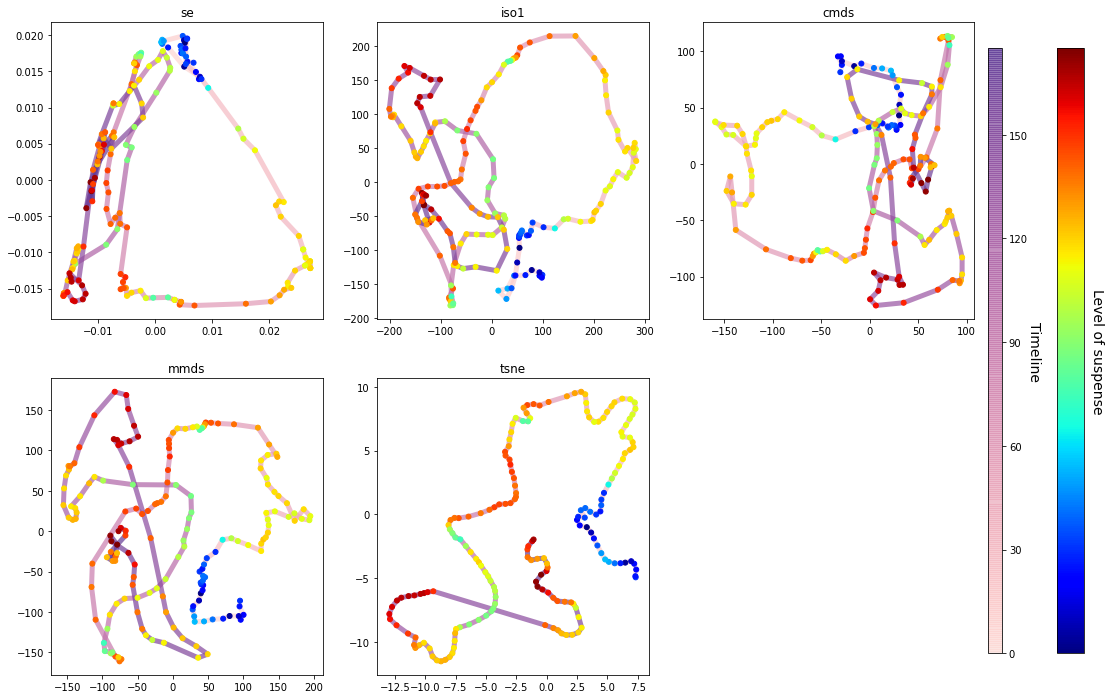

In [23]:
#Plot of five filters: Spectral embedding (se), Isometric Mapping(iso1), Classical multidimensional scaling (cmds), 
#Metric multidimensional scaling (mmds)and #t-distributed stochastic neighbor embedding (tsne)

#We selected for the next step isomap filter

#cols=len(embs[i])
cols=3
rows=2
fig=plt.figure(figsize=(5*cols+4,6*rows))

gs = gridspec.GridSpec(rows, cols)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes. 
#color=truncate_colormap(plt.get_cmap('Purples'),0.2,1,n=200)
#cmap=sns.color_palette("flare", as_cmap=True)
pal  = sequential_hcl("Purple-Orange", rev = True)
color=pal.cmap(300)

for j in range(len(embs[i])):
    key=list(embs[0].keys())[j]
    emb=embs[i][key]
    ax=plt.subplot(gs[j])
    l=emb.shape[0]
    
    plt.title(key) #title
    #line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=1,linewidth=2,zorder=1) #time-line
    line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=0.7,linewidth=5,zorder=1) #time-line
    im=plt.scatter(emb[:,0],emb[:,1],s=25, c=suspense[10:10+t_s],cmap=plt.get_cmap('jet'))
    #im=plt.scatter(emb[:,0],emb[:,1],s=25, c=y,cmap=plt.get_cmap('jet'))#dots

fig.subplots_adjust(right=0.8)
cbar1_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7]) #x-postion, y-position, width, height
cbar1=fig.colorbar(im,cax=cbar1_ax)
cbar1.ax.set_ylabel('Level of suspense',rotation=270,fontsize=14,labelpad=20)
cbar1.set_ticks([])
cbar2_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
cbar2=fig.colorbar(line,cax=cbar2_ax,ticks=np.arange(0,175,30)/175)
cbar2.ax.set_ylabel('Timeline',rotation=270,fontsize=14,labelpad=13)
_=cbar2.ax.set_yticklabels([str(i) for i in np.arange(0,175,30)])
#fig.savefig('../Imagenes/thesis/'+names[i]+'_filts.pdf',bbox_inches='tight')

In [24]:
#saving filters
for i in range(3):
    np.save('../Data/filts/'+names_filts[i]+'.npy',array[i,:,:].astype(np.float64))

[]

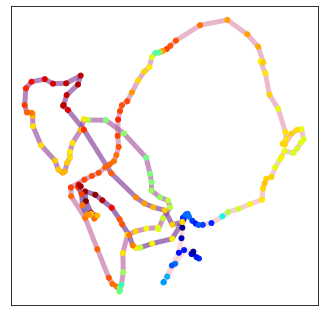

In [121]:
#Plotting isomap filter
i=0
fig,ax = plt.subplots(figsize=(5.5,5.5))
emb=embs[i]["iso1"]
l=emb.shape[0]
#color=truncate_colormap(plt.get_cmap('Purples'),0.2,1,n=200)
#cmap=sns.color_palette("flare", as_cmap=True)
pal  = sequential_hcl("Purple-Orange", rev = True)
color=pal.cmap(300)

#line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=1,linewidth=2,zorder=1) #time-line
line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=0.7,linewidth=5,zorder=1) #time-line
im=plt.scatter(emb[:,0],emb[:,1],s=25, c=suspense[10:10+t_s],cmap=plt.get_cmap('jet')) #dots

ax.set_xticks([])
ax.set_yticks([])

# fig.subplots_adjust(right=0.8,bottom=0.2)
# cbar1_ax = fig.add_axes([0.82, 0.23, 0.04, 0.62]) #left, bottom, width, height
# cbar1=fig.colorbar(im,cax=cbar1_ax)
# cbar1.ax.set_ylabel('Level of suspense',rotation=270,fontsize=14,labelpad=20)
# cbar1.set_ticks([])
# cbar2_ax = fig.add_axes([0.125, 0.15, 0.67, 0.03]) #left, bottom, width, height
# cbar2=fig.colorbar(line,cax=cbar2_ax,ticks=np.arange(0,176,25)/175,orientation='horizontal')
# cbar2.ax.set_xlabel('States',fontsize=14,labelpad=10)
# _=cbar2.ax.set_xticklabels([str(i) for i in np.arange(0,176,25)])
#fig.savefig('../Imagenes/thesis/iso_filt_alone.pdf',bbox_inches='tight') 

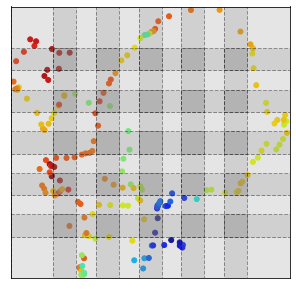

In [38]:
#Plot of filter + rectangular covering
N=6 #Number of intervals
p=0.35 #Percentage of overlapping
L_x=max(emb[:,0])-min(emb[:,0])+10
L_y=max(emb[:,1])-min(emb[:,1])+10
l_x=L_x/(N+p-N*p)
l_y=L_y/(N+p-N*p)

fig,ax = plt.subplots(figsize=(5,5))

emb=embs[0]['iso1']
im=plt.scatter(emb[:,0],emb[:,1],s=25, c=suspense[10:10+t_s],cmap=plt.get_cmap('jet')) #dots

ax.set_xticks([])
ax.set_yticks([])

seq_x=np.arange(min(emb[:,0])-5, max(emb[:,0])+5,l_x*(1-p))
seq_y=np.arange(min(emb[:,1])-5, max(emb[:,1])+5,l_y*(1-p))

rects=[]
for i in range(N):
    for j in range(N):
        rect=Rectangle((seq_x[i],seq_y[j]),l_x,l_y) #(left,bottom), width,height
        rects.append(rect)

fc = colors.to_rgba('gray')
ec = colors.to_rgba('black')

fc = fc[:-1] + (0.2,) # <--- Change the alpha value of facecolor to be 0.7
ec = ec[:-1] + (0.4,)
pc = PatchCollection(rects, facecolor=fc,edgecolor=ec,linestyle='dashed',linewidth=1)
ax.add_collection(pc)

ax.set_xlim(min(emb[:,0])-5, max(emb[:,0])+5)
ax.set_ylim(min(emb[:,1])-5, max(emb[:,1])+5)

fig.savefig('../Imagenes/thesis/iso_filt_cover.pdf',bbox_inches='tight') 

### Distance between matrices of points (considering All-All, no threshold)

In [74]:
i=1

In [58]:
#og_dist=np.load('../Data/dist/all_l1_notemp.npy')
og_dist=np.load('../Data/dist/'+ names[i]+ '.npy')

In [59]:
# new_dist = create_new_dist(og_dist,w)
# mask2=create_mask(w,t_s)

In [60]:
embs[i]={}

In [61]:
n_neigh=30

In [62]:
Aff=affinity_matrix(og_dist,n_neighbors=n_neigh,heat_kernel=False)
#plt.imshow(Aff.toarray())
if(not check_connected(Aff.toarray())):
     raise ValueError('Matrix is not connected')
else:
    se=SpectralEmbedding(n_components=2,affinity='precomputed')
    emb=se.fit_transform(Aff)
embs[i]["se"]=emb
array[3*i,:,:]=emb

In [63]:
iso=Isomap(n_neighbors=n_neigh,n_components=2,metric='precomputed')
#emb=iso.fit_transform(new_dist)
emb=iso.fit_transform(og_dist)
embs[i]["iso1"]=emb
array[3*i+1,:,:]=emb

In [64]:
emb,e=cmdscale(og_dist,2)
embs[i]["cmds"]=emb
array[3*i+2,:,:]=emb

In [65]:
#Equal as cmds
# kPCA=KernelPCA(n_components=2,kernel='precomputed')
# new_dist = og_dist **2
# new_dist*=-0.5
# emb=kPCA.fit_transform(new_dist)
# embs[i]["kPCA"]=emb
# array[3*i+2,:,:]=emb

In [66]:
# emb =my_isomap(new_dist,n_neighbors=30,n_components=2,metric='precomputed',eps=1e-4,max_iter=500,random_states=range(20,21),
#               solver='mmds')

# embs[i]["iso2"]=emb
# array[3*i+2,:,:]=emb

In [67]:
st=4*10**7
for r_state in range(1):
    mds=MDS(n_components=2,metric=True,dissimilarity='precomputed',max_iter=500,random_state=r_state,eps=1e-3)
    new_emb = mds.fit_transform(og_dist)
    #new_emb = mds.fit_transform(og_dist,weights=mask2)
    if (mds.stress_< st):
        emb=new_emb
        st=mds.stress_
        print("st=%s, r=%s" %(st,r_state))
embs[i]["mmds"]=emb
#array[3*i+2,:,:]=emb

st=21138596.168493822, r=0


In [68]:
tsne=TSNE(n_components=2,metric='precomputed',perplexity=40,random_state=1)
emb=(tsne.fit_transform(og_dist))
embs[i]["tsne"]=emb

In [69]:
y=[np.mean(np.array(suspense[i:i+18])) for i in range(t_s)]

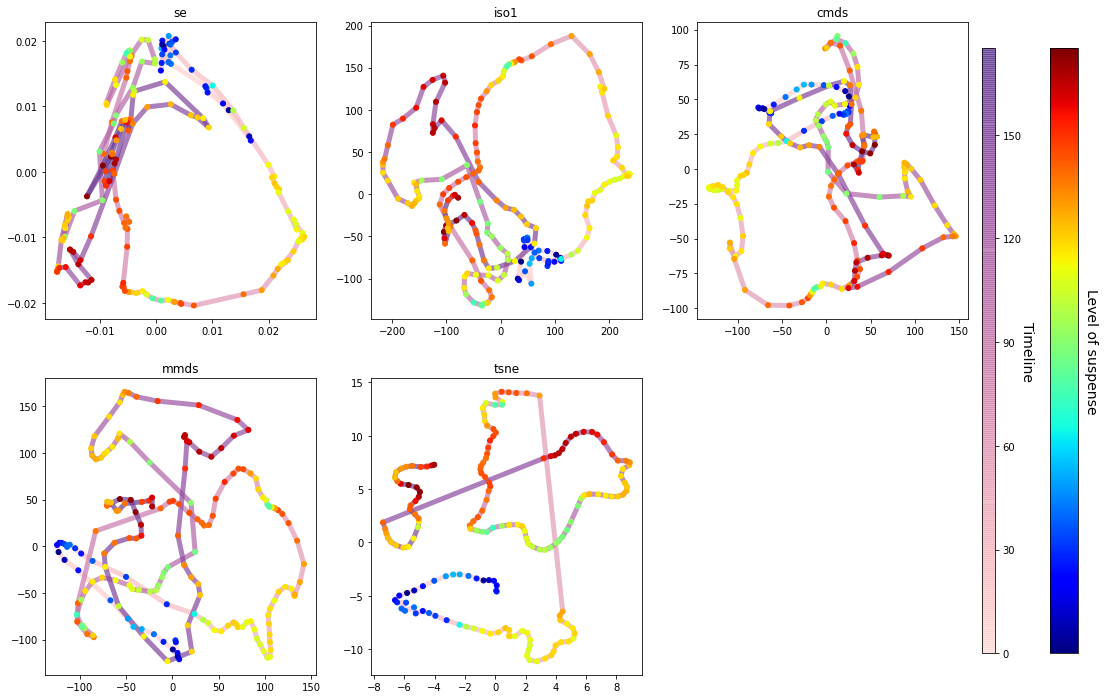

In [71]:
#cols=len(embs[i])
cols=3
rows=2
fig=plt.figure(figsize=(5*cols+4,6*rows))

gs = gridspec.GridSpec(rows, cols)
gs.update(wspace=0.2, hspace=0.2) # set the spacing between axes. 
#color=truncate_colormap(plt.get_cmap('Purples'),0.2,1,n=200)
#cmap=sns.color_palette("flare", as_cmap=True)
pal  = sequential_hcl("Purple-Orange", rev = True)
color=pal.cmap(300)

for j in range(len(embs[i])):
    key=list(embs[i].keys())[j]
    emb=embs[i][key]
    ax=plt.subplot(gs[j])
    l=emb.shape[0]
    
    plt.title(key) #title
    #line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=1,linewidth=2,zorder=1) #time-line
    line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=0.7,linewidth=5,zorder=1) #time-line
    im=plt.scatter(emb[:,0],emb[:,1],s=25, c=suspense[10:10+t_s],cmap=plt.get_cmap('jet'))
    #im=plt.scatter(emb[:,0],emb[:,1],s=25, c=y,cmap=plt.get_cmap('jet'))#dots

fig.subplots_adjust(right=0.8)
cbar1_ax = fig.add_axes([0.86, 0.15, 0.02, 0.7]) #x-postion, y-position, width, height
cbar1=fig.colorbar(im,cax=cbar1_ax)
cbar1.ax.set_ylabel('Level of suspense',rotation=270,fontsize=14,labelpad=20)
cbar1.set_ticks([])
cbar2_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
cbar2=fig.colorbar(line,cax=cbar2_ax,ticks=np.arange(0,175,30)/175)
cbar2.ax.set_ylabel('Timeline',rotation=270,fontsize=14,labelpad=13)
_=cbar2.ax.set_yticklabels([str(i) for i in np.arange(0,175,30)])
fig.savefig('../Imagenes/thesis/'+names[i]+'_filts.pdf',bbox_inches='tight')

In [72]:
for j in range(6):
    np.save('../Data/filts/'+names_filts[j]+'.npy',array[j,:,:].astype(np.float64))

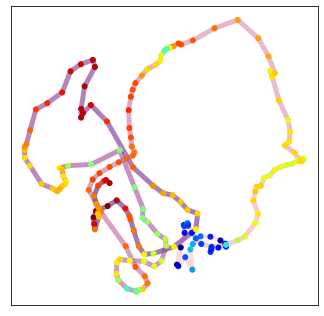

In [75]:
fig,ax = plt.subplots(figsize=(5.5,5.5))
emb=embs[i]["iso1"]
l=emb.shape[0]
#color=truncate_colormap(plt.get_cmap('Purples'),0.2,1,n=200)
#cmap=sns.color_palette("flare", as_cmap=True)
pal  = sequential_hcl("Purple-Orange", rev = True)
color=pal.cmap(300)

#line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=1,linewidth=2,zorder=1) #time-line
line=colorline(emb[:,0],emb[:,1],np.arange(l)/l,cmap=color,alpha=0.7,linewidth=5,zorder=1) #time-line
im=plt.scatter(emb[:,0],emb[:,1],s=25, c=suspense[10:10+t_s],cmap=plt.get_cmap('jet')) #dots

ax.set_xticks([])
ax.set_yticks([])

# fig.subplots_adjust(right=0.8,bottom=0.2)
# cbar1_ax = fig.add_axes([0.82, 0.23, 0.04, 0.62]) #left, bottom, width, height
# cbar1=fig.colorbar(im,cax=cbar1_ax)
# cbar1.ax.set_ylabel('Level of suspense',rotation=270,fontsize=14,labelpad=20)
# cbar1.set_ticks([])
# cbar2_ax = fig.add_axes([0.125, 0.15, 0.67, 0.03]) #left, bottom, width, height
# cbar2=fig.colorbar(line,cax=cbar2_ax,ticks=np.arange(0,176,25)/175,orientation='horizontal')
# cbar2.ax.set_xlabel('States',fontsize=14,labelpad=10)
# _=cbar2.ax.set_xticklabels([str(i) for i in np.arange(0,176,25)])
fig.savefig('../Imagenes/thesis/iso_filt_alone_nothres.pdf',bbox_inches='tight') 

# Random data

### Distance between matrices of points (considering All-All)

In [85]:
i=0

In [86]:
og_dist=np.load('../Data/dist/'+names[i]+'_rand.npy')

In [88]:
embs[i]={}

In [89]:
Aff=affinity_matrix(og_dist,n_neighbors=30,heat_kernel=False)
if(not check_connected(Aff.toarray())):
     raise ValueError('Matrix is not connected')
else:
    se=SpectralEmbedding(n_components=2,affinity='precomputed')
    emb=se.fit_transform(Aff)
embs[i]["se"]=emb
array[3*i,:,:]=emb

In [90]:
iso=Isomap(n_neighbors=30,n_components=2,metric='precomputed')
emb=iso.fit_transform(og_dist)
embs[i]["iso"]=emb
array[3*i+1,:,:]=emb

In [91]:
st=4*10**7
for r_state in range(7,8):
    mds=MDS(n_components=2,metric=True,dissimilarity='precomputed',max_iter=500,random_state=r_state,eps=1e-3)
    new_emb = mds.fit_transform(og_dist,weights=mask2)
    if (mds.stress_< st):
        emb=new_emb
        st=mds.stress_
        print("st=%s, r=%s" %(st,r_state))
embs[i]["mmds"]=emb
array[3*i+2,:,:]=emb

st=4236052.712769586, r=7


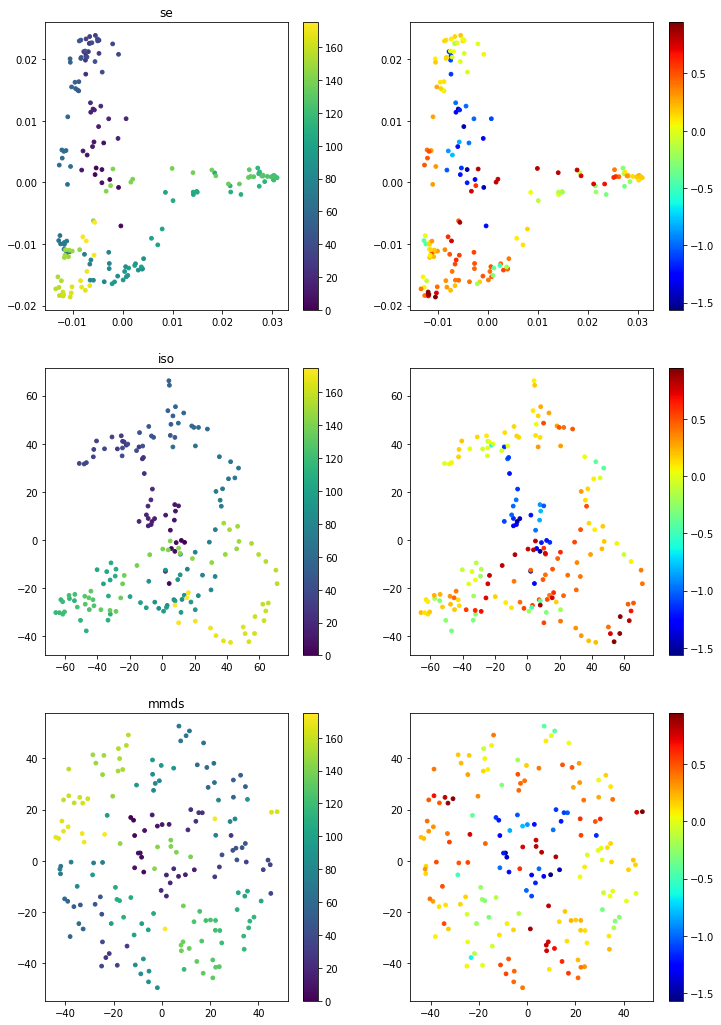

In [92]:
rows=len(embs[i])
plt.figure(figsize=(12,6*rows))
j=0
for key in embs[i].keys():
    j=j+1
    emb=embs[i][key]
    plt.subplot(rows,2,2*j-1)
    plt.title(key)
    plt.scatter(emb[:,0],emb[:,1],s=14, c=range(t_s),cmap=plt.get_cmap('viridis'))
    plt.colorbar()
    plt.subplot(rows,2,2*j)
    plt.scatter(emb[:,0],emb[:,1],s=14, c=suspense[10:10+t_s],cmap=plt.get_cmap('jet'))
    plt.colorbar()
#plt.savefig('../Imagenes/thesis/'+names[i]+'_filts.pdf',bbox_inches='tight')

In [37]:
for i in range(3):
    np.save('../Data/filts/'+names_filts[i]+'_rand.npy',array[i,:,:].astype(np.float64))